# Week 1 lab: Elevator repair

## Goals

* Build a simple model based on synthetic count data: number of elevator failures per year in a building
* Run inference in the model, and make decisions using posterior predictions

## The plan

* load synthetic data: number of elevator failures per year for your building and three nearby buildings
* model data as a Poisson-distributed variable, using a Gamma distribution as a prior over the Poisson intensity
* use posterior predictions about your model to ___

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pystan

%matplotlib inline

### Load the data

In [2]:
failures = pd.read_csv("elevator_failures.csv")
failures

,you,friend1,friend2,friend3
0,2,6,4,2
1,2,1,2,3
2,3,4,2,0
3,4,4,4,2
4,4,5,3,3


## Build the model

Let's assume that the elevator failures happen at a constant probability per time of happening and are uncorrelated with each other- so they'll be described reasonbly well by a homogeneous Poisson process.

The Poisson likelihood has one parameter ($\lambda$) that is equal to both the mean and the standard deviation of the distribution. $\lambda$ has to be nonnegative but doesn't have an upper bound, so we'll use a Gamma distribution.

Prior:

$\lambda \sim gamma(a,b)$

Likelihood:

$y \sim Poisson(\lambda)$

**Note:** numpy uses (`shape`, `scale`) to parameterize Gamma distribution; stan uses (`alpha`, `beta`) where `alpha=shape` and `beta=1/scale`. Example samples from a Gamma distribution:

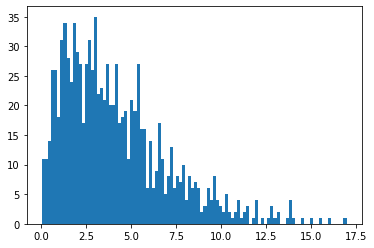

In [3]:
a = 2
b = 2
prior_samples = np.random.gamma(a,b, size=1000)
_ = plt.hist(prior_samples, bins=100);

## Drawing samples from a prior

If we have a likelihood $P(x|\theta)$ and a prior $P(\theta)$, then we can define a prior predictive distribution by marginalizing $\theta$ out,

$P(x) = \int P(x|\theta)P(\theta)d\theta$

which we could then use to sample fake data. This won't be horribly interesting for such a simple model- but as we get to more complicated models, it can be a good early-warning system for catching mistakes. If the prior really does represent our prior knowledge, then sampling data using it should generate data that seems plausible (but broader than the distribution of data we know about). If we get data that looks implausible (for example, violating a law of physics or spread across many orders of magnitude more than the data) then chances are we've mis-specified our priors. From *Visualization in Bayesian workflow*,

> As with the standard concept of weakly informative priors, it is important that this prior predictive distribution for the data has at least some mass around extreme but plausible data sets. On the other hand, there should be no mass on completely implausible data sets. We recommend assessing how informative the prior distribution on the data is by generating a “flip book” of simulated datasets that can be used to investigate the variability and multivariate structure of the distribution

For a simple model like this it'd be easy to use `numpy` to generate prior predictive values- it's also possible to use `stan` for this; let's walk through the process so we can repeat it when we get to more interesting models.

We'll specify prior hyperparameters as our data (which will let us play with them without recompiling the model each time) and use the `generated quantities` block to sample parameters and fake data. Note that no actual inference is happening within this model!

In [4]:
prior_model_code = """
data {
    real alpha;
    real beta;
}
model {
}
generated quantities {
    real lambda;
    int Y;
    lambda = gamma_rng(alpha, beta);
    Y = poisson_rng(lambda);
}
"""

In [5]:
prior_model = pystan.StanModel(model_code=prior_model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9503b06f4404f780d1d0f2a53c6da6b5 NOW.


In [6]:
data = {"alpha":2., "beta":0.5}

When we generate prior samples, we need to run `stan` with the keyword argument `algorithm='Fixed_param'`.

In [7]:
prior_samples = prior_model.sampling(data=data, iter=10000, chains=1, algorithm='Fixed_param')

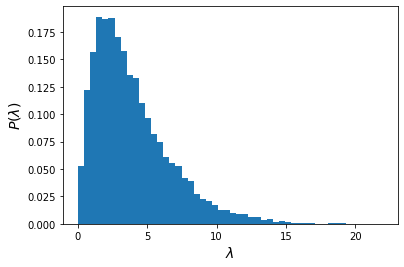

In [8]:
_ = plt.hist(prior_samples.extract()["lambda"], bins=50, density=True)
plt.xlabel("$\lambda$", fontsize=14)
plt.ylabel("$P(\lambda)$", fontsize=14);

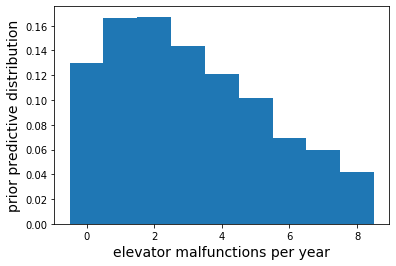

In [9]:
_ = plt.hist(prior_samples.extract()["Y"], bins=np.arange(10)-0.5, density=True)
plt.xlabel("elevator malfunctions per year", fontsize=14)
plt.ylabel("prior predictive distribution", fontsize=14);

Now build the stan model:

In [10]:
model_code = """
data {
    // the data block defines the data structures where our data will go
    // N is the number of observations- an integer with a lower-bound of 0
    int<lower=0> N;
    
    // y is an array of the actual observations (integers with value 0 or 1), of length N
    int<lower=0> y[N];
}
parameters {
    // the parameters block defines the variables we're doing inference on- in
    // this case, just lambda, the poisson "intensity" parameter. 
    
    // for a poisson distribution, this parameter is both the expected mean
    // and the standard deviation
    real<lower=0> lam;
}
model {
    // the model block ties the room together.
    
    // connect the lambda parameter to a prior distribution,
    lam ~ gamma(2,0.5); // specify prior hyperparameters here
    
    // choose a likelihood to connect observations to the lambda parameter
    for (n in 1:N)
        y[n] ~ poisson(lam);
}
generated quantities {
    // we can also have stan generate anything else we want- we'll use this a
    // lot for posterior predictive checks. code in this block is evaluated 
    // once per sample.
    
    // so every time stan draws a value of lambda, let's also have it draw
    // a simulated observation from that value
    vector[N] y_sim;
    
    // generate posterior predictive samples
    for(i in 1:N) {
        y_sim[i] = poisson_rng(lam);
    }
}
"""

In [11]:
%%time
model = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_26194817a265a17191d1cffcc601a036 NOW.


CPU times: user 1.4 s, sys: 57.6 ms, total: 1.45 s
Wall time: 49.3 s


## Draw samples from the posterior

Run inference on the data from your building.

In [12]:
data = {"y":failures["you"], "N":len(failures)}

In [13]:
fit = model.sampling(data=data, iter=10000, chains=4)

In [14]:
fit

Inference for Stan model: anon_model_26194817a265a17191d1cffcc601a036.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lam         3.1  9.0e-3   0.75   1.82   2.57   3.03   3.56   4.76   6846    1.0
y_sim[1]   3.11    0.02   1.93    0.0    2.0    3.0    4.0    8.0  15797    1.0
y_sim[2]    3.1    0.02    1.9    0.0    2.0    3.0    4.0    7.0  15720    1.0
y_sim[3]    3.1    0.02   1.91    0.0    2.0    3.0    4.0    7.0  15858    1.0
y_sim[4]    3.1    0.02   1.91    0.0    2.0    3.0    4.0    7.0  16098    1.0
y_sim[5]   3.08    0.02    1.9    0.0    2.0    3.0    4.0    7.0  15024    1.0
lp__       1.69  8.0e-3    0.7  -0.33   1.54   1.96   2.13   2.18   7707    1.0

Samples were drawn using NUTS at Mon Sep 30 23:56:11 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduct

In [15]:
posterior_samples = fit.extract()["lam"]
posterior_samples.shape

(20000,)

## Trace plots

Before we start interpreting results of our model, we should always check and make sure that MCMC *actually worked*. A standard diagnostic step is to evaluate the samples as a time series- if the goal is to generate random samples from the posterior, then the time series should look like random samples from a stationary distribution (as opposed to a line that slowly meanders around):

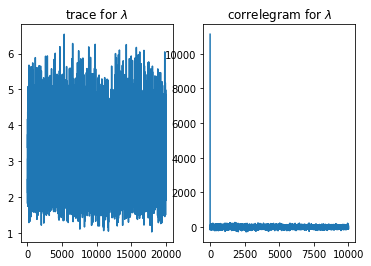

In [16]:
plt.subplot(121)
plt.title("trace for $\lambda$")
plt.plot(posterior_samples)
plt.subplot(122)
plt.title("correlegram for $\lambda$")
plt.plot(np.correlate(posterior_samples-posterior_samples.mean(), 
                      posterior_samples-posterior_samples.mean(), "same")[int(len(posterior_samples)/2):]);

This is what we want to see- consecutive samples are basically uncorrelated. Next week we'll look at a problematic Markov chain.

Since MCMC looks like it worked as intended, let's compare the posterior distribution over $\lambda$ to the prior:

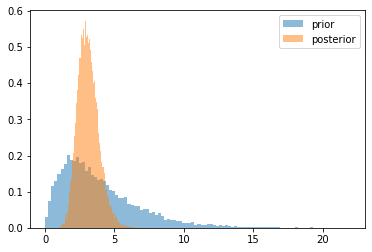

In [17]:
_ = plt.hist(prior_samples.extract()["lambda"], bins=100, density=True, alpha=0.5, label="prior")
_ = plt.hist(posterior_samples, bins=100, density=True, alpha=0.5, label="posterior")
plt.legend(loc="upper right");

## Estimate summary statistics from the posterior

What's the average observed value of $\lambda?$

In [18]:
failures["you"].mean()

3.0

What does our model estimate the average should be?

In [19]:
np.round(posterior_samples.mean(), 2)

3.1

What are the 90% credible intervals- the region that the true value of $\lambda$ has a 90% chance of lying within?

In [20]:
print("95 percent: %s"%np.round(np.quantile(posterior_samples, 0.95),2))
print("5 percent: %s"%np.round(np.quantile(posterior_samples, 0.05),2))

95 percent: 4.43
5 percent: 1.99


## Posterior Predictive Checks

> The idea behind posterior predictive checking is simple: if a model is a good fit we should
be able to use it to generate data that resemble the data we observed.

-from *Visualization in Bayesian workflow* by Gabry *et al*

A final check we're going to do (to build some good Bayesian hygiene before we start building harder models) is the **posterior predictive check.** If our posterior distribution really is a good probabilistic description of our data, then samples from that distribution should look similar to our data.

`y_sim` will be an array of size `(num_samples, num_observations)`; each row represents a simulated dataset.

In [21]:
y_sim = fit.extract()["y_sim"]
y_sim.shape

(20000, 5)

In [22]:
y_sim.max()

16.0

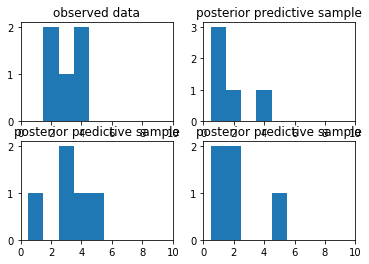

In [26]:
plt.subplot(2,2,1)
bins = np.arange(16) - 0.5
_ = plt.hist(failures["you"], bins=bins)
plt.xlim(0,10)
plt.title("observed data")

for i in range(3):
    plt.subplot(2,2,i+2)
    j = np.random.randint(y_sim.shape[0])
    _ = plt.hist(y_sim[j,:], bins=bins)
    plt.xlim(0,10)
    plt.title("posterior predictive sample");

## Challenge: use your model to make an actual decision

Let's say that the elevator company sells service contracts for repairing broken elevators:

* You can prepay for $N$ service visits per year, at a cost of $N \times $ \$1000 (whether or not you use them all)
* Non-prepaid service visits cost \$1500

**Use your model to predict the value of $N$ that will minimize expected cost**

Suggested approach: write a function that inputs the number of prepaid visits and the number of failures for a given year, and outputs the total cost.

In [19]:
def cost_function(num_failures, n):
    # REMOVE CODE FOR LAB
    if num_failures <= n:
        return n*1000
    else:
        return n*1000 + (num_failures-n)*1500

In [20]:
def cost_function_returns_correct_values():
    # unit test for cost_function()
    assert cost_function(0,1) == 1000
    assert cost_function(1,1) == 1000
    assert cost_function(3,2) == 3500
    
cost_function_returns_correct_values()

The posterior samples we drew are values of $\lambda$, but we need actual failure counts for our cost function. For any $\lambda_{i} \sim P(\lambda |x)$, we can draw a failure count $y_{i} \sim Poisson(\lambda_{i})$ (that is, sampling from the "posterior predictive distribution").

We can use these samples with our cost function to estimate the expected cost of different choices for $N$ (you can do this brute-force style with a `for` loop or two; it doesn't have to be pretty).

In [21]:
# REMOVE CODE FOR LAB
expected_costs = []

for i in range(10):
    expectation_value = np.mean([cost_function(np.random.poisson(lam),i) for lam in posterior_samples])
    expected_costs.append(expectation_value)

Then we just look for a minimum in our expected cost:

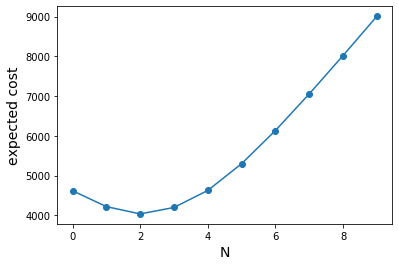

In [22]:
plt.plot(expected_costs, "o-")
plt.xlabel("N", fontsize=14)
plt.ylabel("expected cost", fontsize=14);

## Challenge: reuse your analysis to answer a harder question

Our original dataset contained the historical counts of elevator failures in your building, as well as buildings where three of your friends work. Could you save money if the four of you combined forces with a single shared service plan, or are you better off with four separate plans?

In [17]:
# DELETE CODE FOR THIS ENTIRE SECTION FOR LAB

In [18]:
min_cost = {"you":np.min(expected_costs)}

In [19]:
for f in ["friend1", "friend2", "friend3"]:
    fit = model.sampling(data={"y":failures[f], "N":len(failures)}, iter=10000, chains=4)
    posterior_samples = fit.extract()["lam"]
    expected_costs_f = []

    for i in range(10):
        expectation_value = np.mean([cost_function(np.random.poisson(lam),i) for lam in posterior_samples])
        expected_costs_f.append(expectation_value)
        
    min_cost[f] = np.min(expected_costs_f)

In [20]:
min_cost

{'you': 4038.725, 'friend1': 5098.5, 'friend2': 4023.65, 'friend3': 2974.675}

In [21]:
total_failures = failures.values.sum(axis=1)

In [22]:
total_failures

array([14,  8,  9, 14, 15])

In [23]:
fit = model.sampling(data={"y":total_failures, "N":len(failures)}, iter=10000, chains=4)
posterior_samples = fit.extract()["lam"]
expected_costs_s = []

for i in range(10):
    expectation_value = np.mean([cost_function(np.random.poisson(lam),i) for lam in posterior_samples])
    expected_costs_s.append(expectation_value)
    
shared_min_cost = np.min(expected_costs_s)

In [24]:
# EXPECTED COST FOR RISK POOLING

In [25]:
shared_min_cost

13207.2

In [26]:
# EXPECTED COST FOR INDEPENDENT SERVICE CONTRACTS

In [27]:
np.sum(list(min_cost.values()))

16135.55